# Многослойный перцептрон

## на примере датасета MNIST

### Загрузка стандартных библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 10.0

### Библиотеки машинного обучения: Keras и Scikit-Learn

In [2]:
from sklearn.datasets import fetch_openml, load_digits
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

keras_dataset = True
random_state = 42

first_dense = 512
batch_size = 128
num_classes = 10
epochs = 20

Using TensorFlow backend.


### Описание датасета

In [3]:
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

### Загрузка датасета

Два способа:
- с помощью sklearn
- с помощью keras (данные уже разбиты на тренировочный и тестовый наборы)

In [4]:
# Load dataset
if keras_dataset:
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
else:
    digits = fetch_openml('mnist_784', version=1, cache=True)
    X, y = digits.data, digits.target
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)

y_classes = y_test.copy()

In [5]:
# Shapes for train and test
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

### Изображение - карта признаков

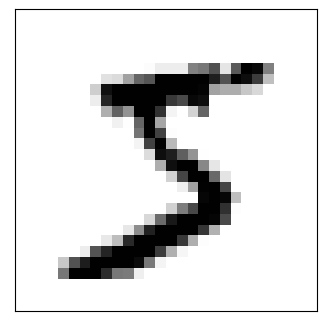

In [6]:
# Plot single digit
plt.figure('Some digit', figsize=(4, 4), dpi=100)
plt.imshow(x_train[0].reshape(28, 28), cmap='binary')
plt.xticks([], [])
plt.yticks([], [])
plt.grid(False)

### Набор рукописных цифр

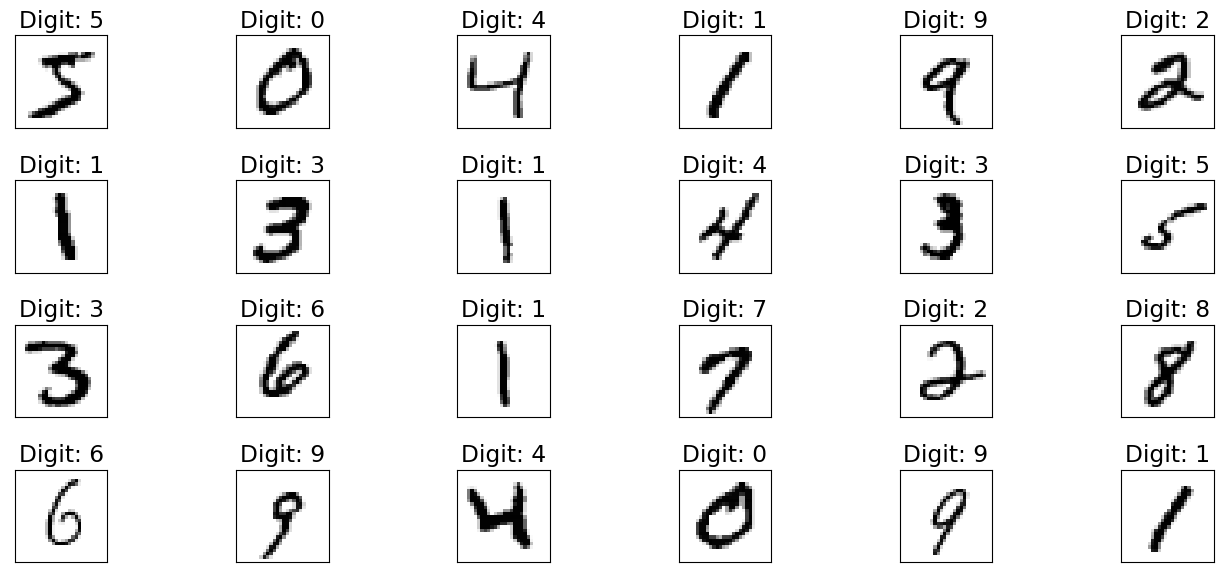

In [7]:
if 1:
    # Plot some digits
    plt.figure('MNIST Dataset', figsize=(14, 6), dpi=100)
    for i in range(24):
        plt.subplot(4, 6, i+1)
        plt.imshow(x_train[i].reshape(28, 28), cmap='binary')
        plt.title('Digit: {}'.format(y_train[i]))
        plt.grid(False)
        plt.xticks([], [])
        plt.yticks([], [])
    plt.tight_layout()

### Подготовка данных

- Преобразование размерностей,
- Масштабирование признаков (нормализация в диапазон [0, 1]),
- Преборазование категориальных меток.

In [8]:
# Prepare data for your model
if keras_dataset:
    N, M = x_train.shape[1], x_train.shape[2]

    x_train = x_train.reshape((60000, N * M))
    x_test = x_test.reshape((10000, N * M))


x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test  samples')

# One-hot label encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

60000 train samples
10000 test  samples


### Многослойный перцептрон

- Полносвязный слой
- Функция активации ReLU
- Полносвязный слой (число нейронов = число классов)
- Фунция активации Softmax

In [9]:
# Create MLP in two steps
model_mlp = Sequential([
    Dense(first_dense, input_shape=(x_train.shape[1], )),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])

model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


### Начальная инициализация нейронов

In [10]:
init_weights = model_mlp.get_weights()

weights_l1 = init_weights[0]
weights_l2 = init_weights[2]

weights_l1.shape, weights_l2.shape

((784, 512), (512, 10))

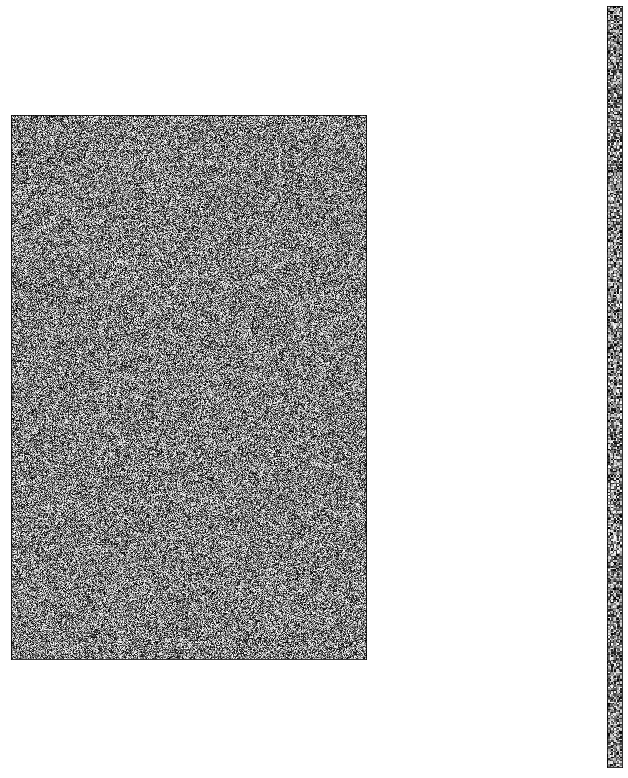

In [11]:
# Plot single digit
plt.figure('Some digit', figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.imshow(weights_l1, cmap='binary')
plt.xticks([], []); plt.yticks([], [])
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(weights_l2, cmap='binary')
plt.xticks([], []); plt.yticks([], [])
plt.grid(False)

### Функция потерь и метрики

- Функция потерь: категориальная кросс-энтропия,
- Метрика: точность (аккуратность),
- Алгоритм - RMS Propagation.


In [12]:
model_mlp.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Обучение модели

In [13]:
hist_mlp = model_mlp.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         workers=4,
                         validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.2591 - accuracy: 0.9248 - val_loss: 0.1439 - val_accuracy: 0.9545
Epoch 2/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.1047 - accuracy: 0.9690 - val_loss: 0.0919 - val_accuracy: 0.9719
Epoch 3/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0689 - accuracy: 0.9798 - val_loss: 0.0760 - val_accuracy: 0.9771
Epoch 4/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0505 - accuracy: 0.9847 - val_loss: 0.0678 - val_accuracy: 0.9808
Epoch 5/20
60000/60000 [==============================] - 3s 42us/step - loss: 0.0374 - accuracy: 0.9888 - val_loss: 0.0699 - val_accuracy: 0.9805
Epoch 6/20
60000/60000 [==============================] - 3s 44us/step - loss: 0.0292 - accuracy: 0.9914 - val_loss: 0.0665 - val_accuracy: 0.9800
Epoch 7/20
60000/60000 [==============================] - 3s 44us/st

### Сохранение результатов модели

In [14]:
# model_mlp.save_weights('model_mlp.h5')

### Точность и потери

In [15]:
mlp_score = model_mlp.evaluate(x_test, y_test)

print(f'Test loss     : {mlp_score[0]},\nTest accuracy : {mlp_score[1]}')

10000/10000 [==============================] - 0s 30us/step
Test loss     : 0.10067701510327347,
Test accuracy : 0.9825000166893005


### График функции потерь и точности на каждой эпохе

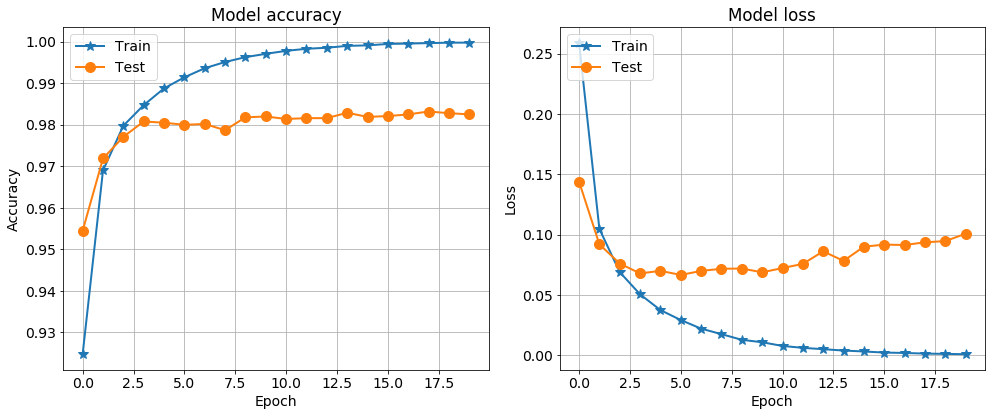

In [16]:
# Plot training & validation loss / accuracy values
plt.figure('Loss & Accuracy', figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(hist_mlp.history['accuracy'], '*-')
plt.plot(hist_mlp.history['val_accuracy'], 'o-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_mlp.history['loss'], '*-')
plt.plot(hist_mlp.history['val_loss'], 'o-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.tight_layout()

### Повторное обучение модели

- Сброс нейронов
- Остановка на **5 эпохе**.

In [17]:
model_mlp.set_weights(init_weights)

hist_mlp = model_mlp.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=5,
                         verbose=1,
                         workers=4,
                         validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 35us/step - loss: 0.2604 - accuracy: 0.9256 - val_loss: 0.1338 - val_accuracy: 0.9613
Epoch 2/5
60000/60000 [==============================] - 2s 36us/step - loss: 0.1049 - accuracy: 0.9691 - val_loss: 0.0875 - val_accuracy: 0.9750
Epoch 3/5
60000/60000 [==============================] - 2s 38us/step - loss: 0.0692 - accuracy: 0.9789 - val_loss: 0.0935 - val_accuracy: 0.9719
Epoch 4/5
60000/60000 [==============================] - 2s 39us/step - loss: 0.0496 - accuracy: 0.9848 - val_loss: 0.0817 - val_accuracy: 0.9763
Epoch 5/5
60000/60000 [==============================] - 2s 39us/step - loss: 0.0380 - accuracy: 0.9887 - val_loss: 0.0652 - val_accuracy: 0.9804


In [18]:
mlp_score = model_mlp.evaluate(x_test, y_test)

print(f'Test loss     : {mlp_score[0]},\nTest accuracy : {mlp_score[1]}')

10000/10000 [==============================] - 0s 33us/step
Test loss     : 0.06522167354075936,
Test accuracy : 0.980400025844574


### Матрица ошибок

In [19]:
y_predict = model_mlp.predict_classes(x_test)

# Confusion matrix
conf_digits = confusion_matrix(y_classes, y_predict)
print(conf_digits)

[[ 972    0    0    0    1    0    2    1    3    1]
 [   0 1125    4    0    0    1    3    0    2    0]
 [   7    1 1001    6    2    0    2    6    7    0]
 [   0    0    1  994    0    2    0    4    5    4]
 [   2    0    4    0  967    0    2    2    0    5]
 [   4    0    0    9    1  862    6    1    6    3]
 [   5    1    0    1    5    2  943    0    1    0]
 [   1    5   11    2    0    0    0 1002    1    6]
 [   4    0    2    3    3    2    2    2  952    4]
 [   2    3    0    4    6    2    0    3    3  986]]


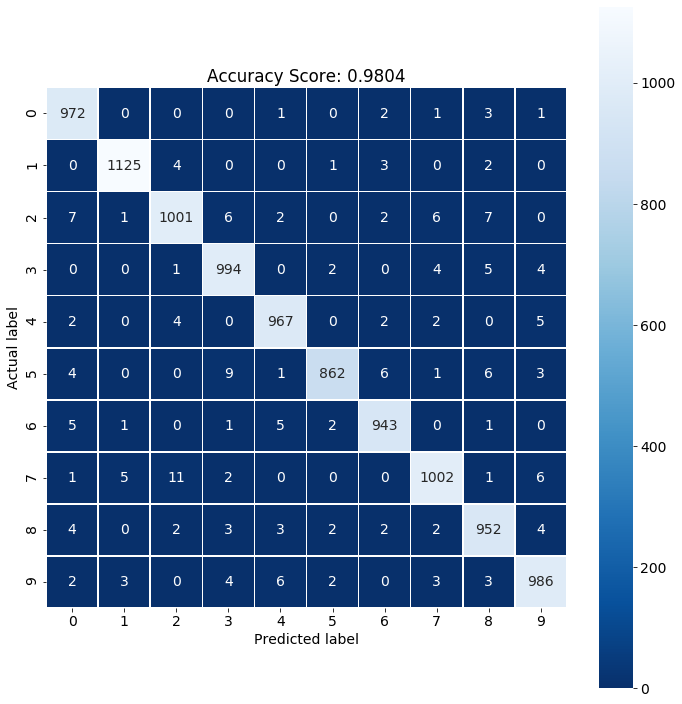

In [20]:
plt.figure('Confusion matrix', figsize=(10, 10))
sns.heatmap(conf_digits, annot=True, linewidths=.75, fmt=".0f", square=True, cmap='Blues_r');
plt.xlabel('Predicted label');
plt.ylabel('Actual label');
plt.title('Accuracy Score: {:.6}'.format(mlp_score[1]));
plt.tight_layout()

### Результат

In [21]:
print(classification_report(y_classes, y_predict))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### Перекрестная проверка

Поиск оптимального числа батчей ```batch_size```

In [22]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [23]:
def create_model():
    model = Sequential()
    model.add(Dense(first_dense, input_shape=(x_train.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
              
    model.compile(loss='categorical_crossentropy', 
                  optimizer=RMSprop(), 
                  metrics=['accuracy'])

    return model

# Create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# Tuning parameters
batch_sizes = [16, 32, 64, 128, 256]
#epochs = [5, 10, 15, 20, 30]
epochs_list = [5]
param_grid = dict(batch_size=batch_sizes, epochs=epochs_list)

grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    n_jobs=4, 
    cv=3)

In [24]:
digits = fetch_openml('mnist_784', version=1, cache=True)
X, y = digits.data, digits.target

X = X.astype('float32') / 255
y = to_categorical(y)

In [25]:
grid_result = grid_search.fit(X, y)

In [26]:
print("Best: %.4f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.9758 using {'batch_size': 16, 'epochs': 5}
0.975829 (0.001285) with: {'batch_size': 16, 'epochs': 5}
0.975600 (0.000246) with: {'batch_size': 32, 'epochs': 5}
0.975786 (0.001396) with: {'batch_size': 64, 'epochs': 5}
0.975057 (0.001433) with: {'batch_size': 128, 'epochs': 5}
0.971757 (0.002018) with: {'batch_size': 256, 'epochs': 5}


### Регуляризация

Добавим слой `Dropout` после каждого полносвязного слоя, за исключением последнего. Этот прием позволит снизить переобучение путём "выключения" доли нейронов в процессе обучения. 

In [27]:
model_do = Sequential()
model_do.add(Dense(first_dense, activation='relu', input_shape=(x_train.shape[1], )))
model_do.add(Dropout(0.5))
model_do.add(Dense(100, activation='relu'))
model_do.add(Dropout(0.2))
model_do.add(Dense(num_classes, activation='softmax'))

model_do.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               51300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 454,230
Trainable params: 454,230
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_do.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
hist_do = model_do.fit(x_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1,
                       workers=4,
                       validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 43us/step - loss: 0.3436 - accuracy: 0.8959 - val_loss: 0.1371 - val_accuracy: 0.9566
Epoch 2/20
60000/60000 [==============================] - 3s 42us/step - loss: 0.1664 - accuracy: 0.9503 - val_loss: 0.0959 - val_accuracy: 0.9712
Epoch 3/20
60000/60000 [==============================] - 3s 53us/step - loss: 0.1306 - accuracy: 0.9617 - val_loss: 0.0847 - val_accuracy: 0.9762
Epoch 4/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.1124 - accuracy: 0.9668 - val_loss: 0.0794 - val_accuracy: 0.9774
Epoch 5/20
60000/60000 [==============================] - 4s 60us/step - loss: 0.0996 - accuracy: 0.9707 - val_loss: 0.0787 - val_accuracy: 0.9780
Epoch 6/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.0905 - accuracy: 0.9742 - val_loss: 0.0733 - val_accuracy: 0.9794
Epoch 7/20
60000/60000 [==============================] - 3s 51us/st

In [30]:
do_score = model_do.evaluate(x_test, y_test)

print(f'Test loss     : {do_score[0]},\nTest accuracy : {do_score[1]}')

10000/10000 [==============================] - 0s 31us/step
Test loss     : 0.08520957594943346,
Test accuracy : 0.982699990272522


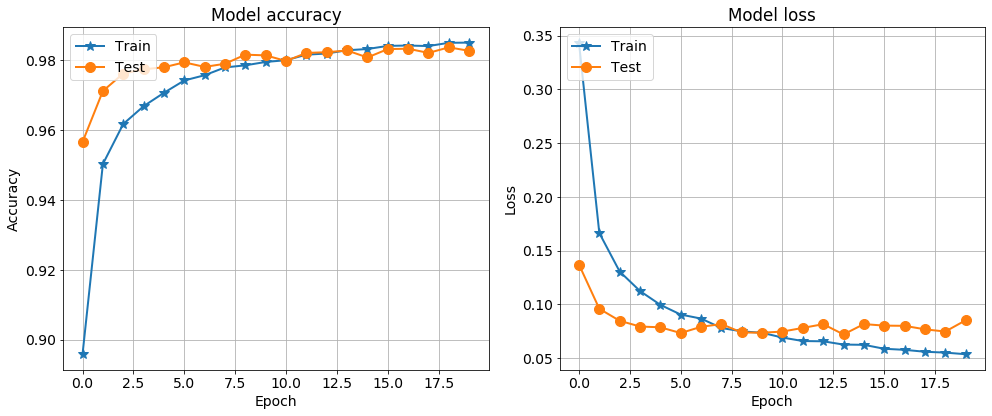

In [31]:
# Plot training & validation loss / accuracy values
plt.figure('Loss & Accuracy', figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(hist_do.history['accuracy'], '*-')
plt.plot(hist_do.history['val_accuracy'], 'o-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_do.history['loss'], '*-')
plt.plot(hist_do.history['val_loss'], 'o-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.tight_layout()

In [32]:
y_predict = model_do.predict_classes(x_test)

# Confusion matrix
conf_digits = confusion_matrix(y_classes, y_predict)
print(conf_digits)

[[ 973    1    0    1    0    1    3    1    0    0]
 [   0 1124    4    1    0    1    2    1    2    0]
 [   4    0 1010    4    1    0    2    8    2    1]
 [   0    0    2  997    0    2    0    6    0    3]
 [   1    0    1    0  961    0    5    4    2    8]
 [   2    0    0   10    1  865    8    2    3    1]
 [   5    2    0    1    1    2  946    0    1    0]
 [   1    1    7    0    0    0    0 1018    0    1]
 [   6    1    2    3    2    3    3    4  944    6]
 [   2    2    0    4    4    1    1    6    0  989]]


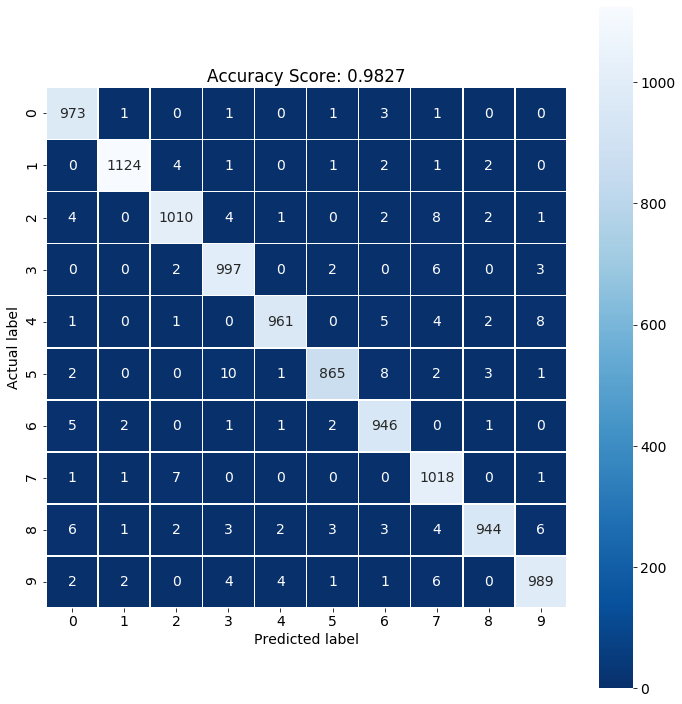

In [33]:
plt.figure('Confusion matrix', figsize=(10, 10))
sns.heatmap(conf_digits, annot=True, linewidths=.75, fmt=".0f", square=True, cmap='Blues_r');
plt.xlabel('Predicted label');
plt.ylabel('Actual label');
plt.title('Accuracy Score: {:.6}'.format(do_score[1]));
plt.tight_layout()